# **Estudiantes:**
- Fabian Tovar
- Felipe García


# Funciones

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [ ]:
# -----------------------------------------------------
# 1.1 Descarga y preprocesamiento
# -----------------------------------------------------

def download_data(tickers, start, end):
    """
    Descarga precios ajustados de cierre de activos.
    """
    data = yf.download(tickers, start=start, end=end, progress=False, auto_adjust=False)["Adj Close"]
    if isinstance(data, pd.Series):  # si es solo un ticker
        data = data.to_frame()
    return data.dropna(how="all")

def preprocess_data(tickers, rf_ticker, start, end):
    """
    Descarga activos + tasa libre de riesgo (^IRX),
    alinea calendarios y elimina faltantes.
    """
    prices_assets = download_data(tickers, start, end)
    prices_rf = download_data(rf_ticker, start, end)
    data_all = prices_assets.join(prices_rf, how="inner").dropna()
    return data_all

# -----------------------------------------------------
# 1.2 Conversión de tasa libre de riesgo
# -----------------------------------------------------

def convert_rf(data_rf: pd.DataFrame):
    """
    Convierte ^IRX (tasa anualizada %) a:
    - tasa anual en decimales
    - tasa diaria efectiva
    """
    rf_ann = data_rf / 100  # convertir de % a proporción
    rf_daily = (1 + rf_ann) ** (1/252) - 1
    rf_ann.columns = [c + "_ann" for c in rf_ann.columns]
    rf_daily.columns = [c + "_daily" for c in rf_daily.columns]
    return rf_ann, rf_daily

# -----------------------------------------------------
# 1.3 Exceso de retorno y exposición
# -----------------------------------------------------

def compute_returns(prices: pd.DataFrame, kind: str = "log"):
    """
    Calcula retornos logarítmicos o simples de los activos de riesgo.
    """
    if kind == "log":
        rets = np.log(prices / prices.shift(1))
    elif kind == "simple":
        rets = prices.pct_change()
    else:
        raise ValueError("kind debe ser 'log' o 'simple'")
    return rets.dropna()

def excess_returns(assets_rets: pd.DataFrame, rf_daily: pd.DataFrame):
    """
    Calcula retornos en exceso de los activos de riesgo frente a rf diaria.
    """
    rf_aligned = rf_daily.reindex(assets_rets.index).fillna(method="ffill")
    ex_rets = assets_rets.sub(rf_aligned.squeeze(), axis=0)
    return ex_rets

# 1. Incorporación del activo libre de riesgo

### 1.1. Descarga y preprocesamiento
- Descargue precios ajustados diarios de los activos de riesgo y de la serie **^IRX** (T-Bill a 13 semanas) usando `yfinance`.
- Alinee calendarios de negociación y elimine faltantes en el rango de fechas definido.

In [3]:
tickers = ["AAPL", "CX", "TSLA", "BTC-USD", "MCD"]
rf_ticker = ["^IRX"]

start_est = "2025-01-01"
end_est = "2025-07-01"

# Descargar y alinear datos
data_all = preprocess_data(tickers, rf_ticker, start_est, end_est)

# Separar activos de riesgo y rf
prices_assets = data_all[tickers]
prices_rf = data_all[rf_ticker]

display("Activos (precios):", prices_assets)

'Activos (precios):'

Ticker,AAPL,CX,TSLA,BTC-USD,MCD
Date,,,,,
2025-01-02,242.987427,5.652203,379.279999,96886.875000,289.190674
2025-01-03,242.499161,5.622402,410.440002,98107.429688,291.434906
2025-01-06,244.133347,5.691937,411.049988,102078.085938,288.864380
2025-01-07,241.353226,5.672070,394.359985,96922.703125,286.056610
2025-01-08,241.841461,5.652203,394.940002,95043.523438,283.644318
...,...,...,...,...,...
2025-06-24,200.072937,6.940000,340.470001,106045.632812,291.470001
2025-06-25,201.331512,6.740000,327.549988,107361.257812,285.549988
2025-06-26,200.772141,6.830000,325.779999,106960.000000,285.630005


### 1.2. Conversión de la tasa libre de riesgo
- Interprete **^IRX** como una tasa anualizada.
- Conviértala a tasa diaria efectiva mediante la fórmula:

$$
r_{day} = (1 + r_{ann})^{1/252} - 1
$$
- Genere series de tasa libre de riesgo diaria y anual.

In [4]:
rf_ann, rf_daily = convert_rf(prices_rf)

print("RF anualizada:", rf_ann.shape)
print("RF diaria:", rf_daily.shape)

RF anualizada: (122, 1)
RF diaria: (122, 1)


### 1.3. Exceso de retorno y exposición
- Devuelva:
  1. Retornos diarios de los activos de riesgo.
  2. Serie de tasa libre de riesgo diaria y anual.
  3. Un indicador que permita trabajar con **retornos en exceso** cuando se calcule el Sharpe ratio o el portafolio tangente.

In [5]:
rets_assets = compute_returns(prices_assets, kind="log")
rets_excess = excess_returns(rets_assets, rf_daily)

/tmp/ipykernel_9405/2632767995.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_aligned = rf_daily.reindex(assets_rets.index).fillna(method="ffill")


In [6]:
print("Retornos activos:", rets_assets.shape)
print("Retornos en exceso:", rets_excess.shape)

Retornos activos: (121, 5)
Retornos en exceso: (121, 5)


# 2. Portafolio media–varianza eficiente

### 2.1 Estadísticos: μ y Σ anualizados

In [7]:
# Retornos diarios 
rets_assets = compute_returns(prices_assets, kind="log")

# µ anualizada (vector de medias)
mu = rets_assets.mean() * 252

# Σ anualizada (matriz de covarianzas)
Sigma = rets_assets.cov() * 252

print("Vector de medias anualizadas (µ):")
print(mu)

print("\nMatriz de covarianzas anualizada (Σ):")
print(Sigma)

Vector de medias anualizadas (µ):
Ticker
AAPL      -0.354685
CX         0.424473
TSLA      -0.369238
BTC-USD    0.209407
MCD        0.021346
dtype: float64

Matriz de covarianzas anualizada (Σ):
Ticker       AAPL        CX      TSLA   BTC-USD       MCD
Ticker                                                   
AAPL     0.164515  0.062497  0.183096  0.060212  0.022654
CX       0.062497  0.164931  0.120094  0.058685  0.019255
TSLA     0.183096  0.120094  0.585327  0.174648  0.007702
BTC-USD  0.060212  0.058685  0.174648  0.182179  0.002897
MCD      0.022654  0.019255  0.007702  0.002897  0.044436


### 2.2 Optimización

In [8]:
import cvxpy as cp

def min_var_portfolio(mu, Sigma, target_return):
    n = len(mu)
    w = cp.Variable(n)

    # Restricciones
    constraints = [
        cp.sum(w) == 1,          # suma de pesos = 1
        mu.values @ w >= target_return,  # retorno objetivo
        w >= 0                   # no short selling
    ]

    # Función objetivo: minimizar varianza
    risk = cp.quad_form(w, Sigma.values)
    problem = cp.Problem(cp.Minimize(risk), constraints)
    problem.solve()

    return w.value, problem.value

### 2.3 Implementación: frontera media–varianza

In [9]:
def efficient_frontier(mu, Sigma, n_points=50):
    mus = np.linspace(mu.min(), mu.max(), n_points)
    risks = []
    weights = []

    for m in mus:
        w_opt, var_opt = min_var_portfolio(mu, Sigma, m)
        if w_opt is not None:
            risks.append(np.sqrt(var_opt))  # desviación estándar (volatilidad)
            weights.append(w_opt)

    return mus, risks, weights


In [10]:
def mean_variance_efficient(mu, Sigma, n_points=50, plot=True):
    """
    Calcula y  grafica la frontera eficiente media-varianza.
    
    Parámetros
    ----------
    mu : pd.Series
        Vector de retornos esperados anualizados (µ).
    Sigma : pd.DataFrame
        Matriz de covarianzas anualizada (Σ).
    n_points : int
        Número de puntos en la frontera.
    plot : bool
        Si True, grafica la frontera eficiente.
    
    Retorna
    -------
    mus : list
        Retornos esperados de los portafolios eficientes.
    risks : list
        Volatilidades (σ) de los portafolios eficientes.
    weights : list
        Pesos óptimos de cada portafolio.
    """
    mus, risks, weights = efficient_frontier(mu, Sigma, n_points)

    #if plot:
        #plt.figure(figsize=(8,6))
        #plt.plot(risks, mus, "b-", linewidth=2, label="Frontera Eficiente")
        #plt.xlabel("Volatilidad (σ)")
        #plt.ylabel("Retorno esperado (µ)")
        #plt.title("Portafolio Media–Varianza Eficiente")
        #plt.grid(True)
        #plt.legend()
        #plt.show()
    
    return mus, risks, weights


# Ejemplo de uso con tus µ y Σ
mus, risks, weights = mean_variance_efficient(mu, Sigma, n_points=100, plot=True)

print("pesos del portafolio con retorno objetivo más alto:")
print(dict(zip(mu.index, weights[-1])))


pesos del portafolio con retorno objetivo más alto:
{'AAPL': np.float64(-3.95861617543186e-22), 'CX': np.float64(0.9999999999999997), 'TSLA': np.float64(-2.411430486951568e-22), 'BTC-USD': np.float64(3.451101430620171e-16), 'MCD': np.float64(-9.837021741166959e-23)}


# 3. Curva eficiente

### 3.1 Construcción de la frontera eficiente

In [11]:
mus, risks, weights = efficient_frontier(mu, Sigma, n_points=1000)


### 3.2 Gráfico Volatilidad vs Retorno esperado

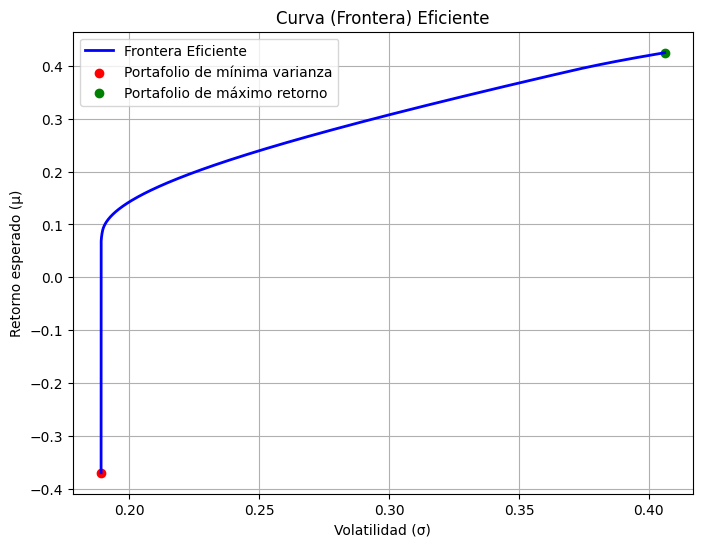

In [12]:
plt.figure(figsize=(8,6))
plt.plot(risks, mus, "b-", linewidth=2, label="Frontera Eficiente")
plt.scatter(risks[0], mus[0], color="red", label="Portafolio de mínima varianza")
plt.scatter(risks[-1], mus[-1], color="green", label="Portafolio de máximo retorno")
plt.xlabel("Volatilidad (σ)")
plt.ylabel("Retorno esperado (µ)")
plt.title("Curva (Frontera) Eficiente")
plt.legend()
plt.grid(True)
plt.show()

# 4. Portafolios especiales

### 4.1. Determine el portafolio de mínima varianza (PMV).


In [13]:
def min_variance_portfolio(mu, Sigma):
    """
    Calcula el portafolio de mínima varianza (PMV).
    """
    n = len(mu)
    w = cp.Variable(n)
    
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]
    
    risk = cp.quad_form(w, Sigma.values)
    problem = cp.Problem(cp.Minimize(risk), constraints)
    problem.solve()
    
    return w.value, problem.value


w_pmv, var_pmv = min_variance_portfolio(mu, Sigma)
ret_pmv = mu.values @ w_pmv
vol_pmv = np.sqrt(var_pmv)

print("Pesos PMV:", dict(zip(mu.index, w_pmv)))
print(f"Retorno esperado (µ): {ret_pmv:.4f}")
print(f"Volatilidad (σ): {vol_pmv:.4f}")


Pesos PMV: {'AAPL': np.float64(0.03460350183012972), 'CX': np.float64(0.061655814794729445), 'TSLA': np.float64(3.6084366965383585e-23), 'BTC-USD': np.float64(0.15311070210160793), 'MCD': np.float64(0.7506299812735329)}
Retorno esperado (µ): 0.0620
Volatilidad (σ): 0.1891


### 4.2. Determine el portafolio tangente (máximo ratio de Sharpe) incorporando el activo libre de riesgo.

In [14]:
def tangency_portfolio(mu, Sigma, rf):
    """
    Calcula el portafolio tangente (máximo Sharpe).
    
    Parámetros:
    - mu : pd.Series, retornos esperados anualizados
    - Sigma : pd.DataFrame, matriz de covarianza anualizada
    - rf : float, tasa libre de riesgo anualizada (en decimales)
    """
    n = len(mu)
    w = cp.Variable(n)
    
    # Retorno en exceso
    excess_ret = mu.values @ w - rf
    
    # Restricciones
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.quad_form(w, Sigma.values) <= 1   # normalización para convexidad
    ]
    
    # Objetivo: maximizar retorno en exceso (equivalente a Sharpe)
    problem = cp.Problem(cp.Maximize(excess_ret), constraints)
    problem.solve()
    
    # Obtener métricas reales (sin la normalización artificial)
    w_opt = w.value
    ret_opt = mu.values @ w_opt
    vol_opt = np.sqrt(w_opt.T @ Sigma.values @ w_opt)
    sharpe_opt = (ret_opt - rf) / vol_opt
    
    return w_opt, ret_opt, vol_opt, sharpe_opt


rf_ann_scalar = float(rf_ann.iloc[-1])  # última tasa anualizada
w_tan, ret_tan, vol_tan, sharpe_tan = tangency_portfolio(mu, Sigma, rf_ann_scalar)

print("Pesos portafolio tangente:", dict(zip(mu.index, w_tan)))
print(f"Retorno esperado (µ): {ret_tan:.4f}")
print(f"Volatilidad (σ): {vol_tan:.4f}")
print(f"Sharpe ratio: {sharpe_tan:.4f}")

Pesos portafolio tangente: {'AAPL': np.float64(1.9862275286295813e-11), 'CX': np.float64(0.9999999976522431), 'TSLA': np.float64(1.5336156740900243e-10), 'BTC-USD': np.float64(8.88275666995511e-10), 'MCD': np.float64(1.2862613540844298e-09)}
Retorno esperado (µ): 0.4245
Volatilidad (σ): 0.4061
Sharpe ratio: 0.9420


/tmp/ipykernel_9405/4283568827.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rf_ann_scalar = float(rf_ann.iloc[-1])  # última tasa anualizada


# 5. Comparacion de metodologias

### 5.1. Usando los datos del periodo de estimacion (ene 2025 – jul 2025), calcule los pesos optimos para:
-   Portafolio media–varianza.
-   Portafolio tangente.
-   Portafolio optimo segun Monte Carlo (max. Sharpe).

In [ ]:
# mu: El vector de retornos medios anualizados de los activos.
# Sigma: La matriz de covarianzas anualizada.
# w_pmv: Los pesos del Portafolio de Mínima Varianza.

# Media (Retorno Esperado) del Portafolio 
# Se calcula como el producto punto entre el vector de pesos y el de retornos medios.
# Formula: w^T * μ
retorno_portafolio = mu.T @ w_pmv

# Varianza del Portafolio 
# Se calcula con la fórmula matricial w^T * Σ * w
varianza_portafolio = w_pmv.T @ Sigma @ w_pmv

# --- Resultados ---
print(f"Estadísticas para el Portafolio de Mínima Varianza (PMV):")
print(f"  - Retorno Esperado (Media) Anualizado: {retorno_portafolio:.4f}")
print(f"  - Varianza Anualizada del Portafolio: {varianza_portafolio:.4f}")

# calcular la volatilidad (desviación estándar)
volatilidad_portafolio = np.sqrt(varianza_portafolio)
print(f"  - Volatilidad (desviacion estandar) Anualizada del Portafolio: {volatilidad_portafolio:.4f}")

Estadísticas para el Portafolio de Mínima Varianza (PMV):
  - Retorno Esperado (Media) Anualizado: 0.0620
  - Varianza Anualizada del Portafolio: 0.0358
  - Volatilidad (desviacion estandar) Anualizada del Portafolio: 0.1891
